In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
vice.yields.ccsne.settings["mg"] = 0.00261
vice.yields.sneia.settings["mg"] = 0
from scipy.stats import multivariate_normal
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/gsechem.dat")
data = {}
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]
# data["age"] = [10**_ for _ in raw[:, 4]]
# data["age_err"] = [10**a * b * m.log(10) for a, b in zip(data["age"], raw[:, 5])]

raw = np.genfromtxt("../data/gsechem_noages_25600.out")
chain = {}
chain["tau_in"] = raw[:, 0]
chain["tau_star"] = raw[:, 1]
chain["eta"] = raw[:, 2]
chain["tau_tot"] = raw[:, 3]
chain["logp"] = raw[:, 4]

Median [Fe/H] error: 0.0496
Median [Mg/Fe] error: 0.0465


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


199


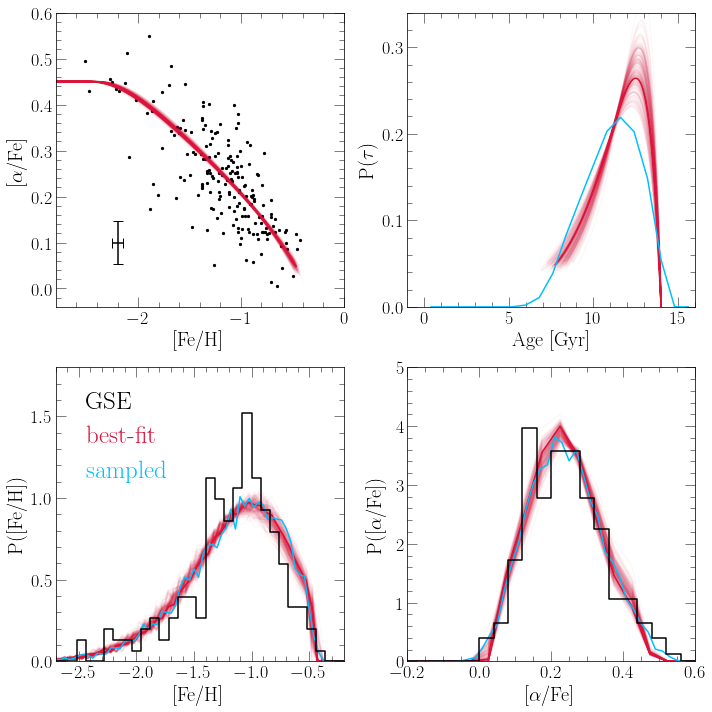

In [6]:
fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)

axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel(r"[$\alpha$/Fe]")
axes[0][0].set_xlim([-2.8, 0])
axes[0][0].set_ylim([-0.04, 0.6])

med_ofe_err = np.median(data["[o/fe]_err"])
med_feh_err = np.median(data["[fe/h]_err"])
print("Median [Fe/H] error: %.4f" % (med_feh_err))
print("Median [Mg/Fe] error: %.4f" % (med_ofe_err))
kwargs = {
    "c": named_colors()["black"],
    "xerr": med_feh_err,
    "yerr": med_ofe_err,
    "linestyle": "None"
}
axes[0][0].errorbar(-2.2, 0.1, **kwargs)

endtime = 6.25
with vice.singlezone(name = "bestfit") as sz:
#     sz.elements = ["fe", "mg"]
    sz.func = exponential(timescale = 1.35)
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 24.26
    sz.eta = 13.71
    sz.dt = endtime / 1000
    out = sz.run(np.linspace(0, endtime, 1001), overwrite = True, capture = True)
    axes[0][0].plot(out.history["[fe/h]"], out.history["[o/fe]"],
        c = named_colors()["crimson"])

kwargs = {
    "s": 5,
    "c": named_colors()["black"]
}
# hasages = list(filter(lambda _: not np.isnan(data["age"][_]), range(len(data["age"]))))
# noages = list(filter(lambda _: np.isnan(data["age"][_]), range(len(data["age"]))))
# xvals = [data["[fe/h]"][_] for _ in noages]
# yvals = [data["[o/fe]"][_] for _ in noages]
# axes[0][0].scatter(xvals, yvals, **kwargs)
axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

# kwargs["c"] = [data["age"][_] for _ in hasages]
# kwargs["vmin"] = 0
# kwargs["vmax"] = 14
# kwargs["cmap"] = "viridis"
# xvals = [data["[fe/h]"][_] for _ in hasages]
# yvals = [data["[mg/fe]"][_] for _ in hasages]
# sc = axes[0][0].scatter(xvals, yvals, **kwargs)

# cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
# cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
# cbar.set_label("Age [Gyr]", labelpad = 5)
# cbar.set_ticks(range(0, 16, 2))



axes[0][1].set_xlabel("Age [Gyr]")
axes[0][1].set_ylabel(r"P($\tau$)")
axes[0][1].set_xlim([-1, 16])
# axes[0][1].set_xticks([0, 2, 4, 6, 8, 10])
axes[0][1].set_ylim([0, 0.34])
axes[0][1].set_yticks([0, 0.1, 0.2, 0.3])
shift = 14 - endtime
# hist, bins = np.histogram(data["age"], bins = 20, range = [0, 16], density = True)
# axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["black"])
xvals = [_ + shift for _ in out.history["lookback"]]
dt = out.history["time"][1] - out.history["time"][0]
norm = sum(out.history["sfr"]) * dt
agedist = [_ / norm for _ in out.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["crimson"])

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.7, -0.2])
axes[1][0].set_ylim([0, 1.8])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5])
hist, bins = np.histogram(data["[fe/h]"], bins = 50, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["black"],
    label = "GSE", zorder = 100)
xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
axes[1][0].plot(xvals, out.mdf["dn/d[fe/h]"], c = named_colors()["crimson"],
    label = "best-fit")

axes[1][1].set_xlabel(r"[$\alpha$/Fe]")
axes[1][1].set_ylabel(r"P([$\alpha$/Fe])", labelpad = 10)
axes[1][1].set_xlim([-0.2, 0.6])
axes[1][1].set_ylim([0, 5])
hist, bins = np.histogram(data["[o/fe]"], bins = 50, range = [-1, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["black"], zorder = 100)
axes[1][1].plot(xvals, out.mdf["dn/d[o/fe]"], c = named_colors()["crimson"])

n_subs = 200
minlogp = min(chain["logp"])
logp = [_ - minlogp for _ in chain["logp"]]
prob = [m.exp(_) for _ in logp]
norm = sum(prob)
prob = [_ / norm for _ in prob]
indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
kwargs = {
    "c": named_colors()["crimson"],
    "alpha": 0.03
}
with vice.singlezone(name = "sampled") as sz:
    for i in range(n_subs):
        sz.func = exponential(timescale = chain["tau_in"][indeces[i]])
        sz.mode = "ifr"
        sz.Mg0 = 0
        sz.nthreads = 2
        sz.tau_star = chain["tau_star"][indeces[i]]
        sz.eta = chain["eta"][indeces[i]]
        sz.dt = chain["tau_tot"][indeces[i]] / 500
        out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501),
            overwrite = True, capture = True)

        axes[0][0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)

        dt = out.history["time"][1] - out.history["time"][0]
        norm = sum(out.history["sfr"]) * dt
        agedist = [_ / norm for _ in out.history["sfr"]]
        xvals = [_ + 14 - chain["tau_tot"][indeces[i]] for _ in out.history["lookback"]]
        axes[0][1].plot(xvals, agedist, **kwargs)

        xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
        axes[1][0].plot(xvals, out.mdf["dn/d[fe/h]"], **kwargs)
        axes[1][1].plot(xvals, out.mdf["dn/d[o/fe]"], **kwargs)

        sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

norm = sum(out.history["sfr"])
sfrfrac = [_ / norm for _ in out.history["sfr"]]
indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e4))
ages = [out.history["lookback"][_] + 14 - endtime for _ in indeces]
for i in range(len(ages)):
    while True:
        testval = 10**(m.log10(ages[i]) + np.random.normal(scale = 0.05))
        if testval <= 14:
            ages[i] = testval
            break
        else:
            continue
feh = [out.history["[fe/h]"][_] + np.random.normal(scale = med_feh_err) for _ in indeces]
ofe = [out.history["[o/fe]"][_] + np.random.normal(scale = med_ofe_err) for _ in indeces]
# axes[0][0].scatter(feh, ofe, c = named_colors()["deepskyblue"], s = 5)
hist, bins = np.histogram(ages, bins = 20, range = [0, 16], density = True)
xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
axes[0][1].plot(xvals, hist, c = named_colors()["deepskyblue"])
# axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"])
hist, bins = np.histogram(feh, bins = 100, range = [-3, 1], density = True)
xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
axes[1][0].plot(xvals, hist, c = named_colors()["deepskyblue"], label = "sampled")
# axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"])
hist, bins = np.histogram(ofe, bins = 100, range = [-1, 1], density = True)
xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
axes[1][1].plot(xvals, hist, c = named_colors()["deepskyblue"])
# axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"])


kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 25
}
leg = axes[1][0].legend(**kwargs)
fancy_legend(leg, ["black", "crimson", "deepskyblue"])

plt.tight_layout()
# plt.subplots_adjust(wspace = 0.4)
# axes[0][0].set_position([
#     axes[0][0].get_position().x0,
#     axes[0][0].get_position().y0,
#     axes[0][0].get_position().x1 - axes[0][0].get_position().x0 - 0.025,
#     axes[0][0].get_position().y1 - axes[0][0].get_position().y0
# ])
# cbar_ax.set_position([
#     axes[0][0].get_position().x1,
#     axes[0][0].get_position().y0,
#     0.025,
#     axes[0][0].get_position().y1 - axes[0][0].get_position().y0
# ])
# for ext in ["pdf", "jpeg"]: plt.savefig("./GSE_distributions.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("../data/gsechem_orig_distributions.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("../data/gsechem_orig_distcomp.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("../data/gsechem_withages_distributions.%s" % (ext))
for ext in ["pdf", "jpeg"]: plt.savefig("../data/gsechem_noages_distribution.%s" % (ext))
plt.show()

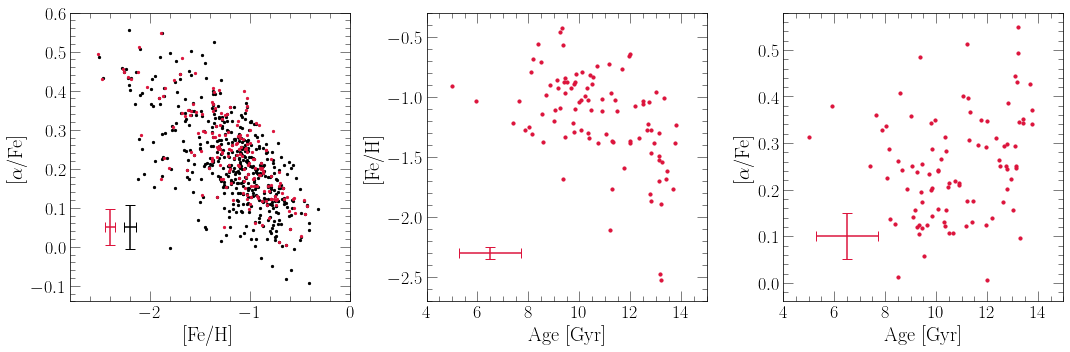

In [4]:
orig_raw = np.genfromtxt("../data/gsechem_orig.dat")
orig = {}
orig["[fe/h]"] = orig_raw[:, 0]
orig["[fe/h]_err"] = orig_raw[:, 1]
orig["[o/fe]"] = orig_raw[:, 2]
orig["[o/fe]_err"] = orig_raw[:, 3]

small_raw = np.genfromtxt("../data/gsechem.dat")
small = {}
small["[fe/h]"] = small_raw[:, 0]
small["[fe/h]_err"] = small_raw[:, 1]
small["[o/fe]"] = small_raw[:, 2]
small["[o/fe]_err"] = small_raw[:, 3]
small["age"] = [10**_ for _ in small_raw[:, 4]]
small["age_err"] = [a * b * m.log(10) for a, b in zip(small["age"], small_raw[:, 5])]

hasages_raw = np.array(list(filter(lambda x: not m.isnan(x[-2]), small_raw)))
hasages = {}
hasages["[fe/h]"] = hasages_raw[:, 0]
hasages["[fe/h]_err"] = hasages_raw[:, 1]
hasages["[o/fe]"] = hasages_raw[:, 2]
hasages["[o/fe]_err"] = hasages_raw[:, 3]
hasages["age"] = [10**_ for _ in hasages_raw[:, 4]]
hasages["age_err"] = [a * b * m.log(10) for a, b in zip(hasages["age"], hasages_raw[:, 5])]

fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3): axes.append(fig.add_subplot(131 + i))

axes[0].set_xlabel("[Fe/H]")
axes[0].set_ylabel(r"[$\alpha$/Fe]")
axes[0].set_xlim([-2.8, 0])
axes[0].set_ylim([-0.14, 0.6])

kwargs = {"s": 5}
axes[0].scatter(orig["[fe/h]"], orig["[o/fe]"], c = named_colors()["black"], **kwargs)
axes[0].scatter(small["[fe/h]"], small["[o/fe]"], c = named_colors()["crimson"], **kwargs)

med_ofe_err = np.median(orig["[o/fe]_err"])
med_feh_err = np.median(orig["[fe/h]_err"])
kwargs = {
    "xerr": med_feh_err,
    "yerr": med_ofe_err,
    "linestyle": "None"
}
axes[0].errorbar(-2.2, 0.05, c = named_colors()["black"], **kwargs)
med_ofe_err = np.median(small["[o/fe]_err"])
med_feh_err = np.median(small["[fe/h]_err"])
kwargs["xerr"] = med_feh_err
kwargs["yerr"] = med_ofe_err
axes[0].errorbar(-2.4, 0.05, c = named_colors()["crimson"], **kwargs)

med_age_err = np.median(hasages["age_err"])
for i in [1, 2]: 
    axes[i].set_xlabel("Age [Gyr]")
    axes[i].set_xlim([4, 15])
    axes[i].set_xticks([4, 6, 8, 10, 12, 14])
axes[1].set_ylabel("[Fe/H]")
axes[2].set_ylabel(r"[$\alpha$/Fe]")
axes[1].set_ylim([-2.7, -0.3])
axes[2].set_ylim([-0.04, 0.58])
kwargs = {
    "s": 10,
    "c": named_colors()["crimson"]
#     "xerr": hasages["age_err"],
#     "yerr": hasages["[fe/h]_err"],
#     "linestyle": "None"
}
axes[1].scatter(hasages["age"], hasages["[fe/h]"], **kwargs)
# kwargs["yerr"] = small["[o/fe]_err"]
axes[2].scatter(hasages["age"], hasages["[o/fe]"], **kwargs)

del kwargs["s"]
axes[1].errorbar(6.5, -2.3, xerr = med_age_err, yerr = med_feh_err, linestyle = "None", **kwargs)
axes[2].errorbar(6.5, 0.1, xerr = med_age_err, yerr = med_feh_err, linestyle = "None", **kwargs)

plt.tight_layout()
plt.subplots_adjust(left = 0.07)
for ext in ["pdf", "jpeg"]: plt.savefig("../data/GSE_samples.%s" % (ext))